# ドカーンと動いたら逆張り

In [1]:
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'IPAPGothic'
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import datetime
from statistics import mean
from statistics import median
import calendar
import datetime
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb
import math

In [2]:
# OANDA API v20の口座IDとAPIトークン
accountID = "101-009-12609641-001"
access_token = "11f2a77cf99d3d29afc4c1cb1a0fb36b-e0fc1d1bf476926157f1d5992466fdf4"
# OANDAのデモ口座へのAPI接続
api = API(access_token=access_token, environment="practice")

## 関数定義

In [3]:
# APIから取得したレートをPandasのDataFrameへ
def to_dataframe(r):
    data = []
    for raw in r.response['candles']:
        data.append([raw['time'], raw['volume'], raw['mid']['o'], raw['mid']['h'], raw['mid']['l'], raw['mid']['c']])

    # リストからPandas DataFrameへ変換
    df = pd.DataFrame(data)
    df.columns = ['Time', 'Volume', 'Open', 'High', 'Low', 'Close']
    df['Time'] = pd.to_datetime(df['Time'])
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col].apply(float)
    return df

In [4]:
# 第何何曜日（第nX曜日）の日付を返す関数
def get_day_of_nth_dow(year, month, nth, dow):
    '''dow: Monday(0) - Sunday(6)'''
    if nth < 1 or dow < 0 or dow > 6:
        return None

    first_dow, n = calendar.monthrange(year, month)
    day = 7 * (nth - 1) + (dow - first_dow) % 7 + 1

    return day if day <= n else None

In [5]:
def get_data(count, gran, year, month, day, hour, minute, second):
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    _from = datetime.datetime(year=year, month=month, day=day,
                              hour=hour, minute=minute, second=second).strftime(fmt)
    params = {
        "count": count,
        "granularity": gran,
        'from': _from,
#         'dailyAlignment': 0
    }
    r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
    api.request(r)
    df = to_dataframe(r)
    return df

In [6]:
def get_data_super(start, end, gran):
    # OANDA API v20の口座IDとAPIトークン
    accountID = "101-009-12789646-001"
    access_token = "1ab53171ce4413f408de6da28ea23089-6426c3d3cc947dba212b3766d1be45c6"
    # OANDAのデモ口座へのAPI接続
    api = API(access_token=access_token, environment="practice")
    # xxxx-xx-xx～xxxx-xx-xx の期間のデータを取得してデータフレームを返す
    s_year, s_month, s_day, s_hour, s_minute, s_second = map(int, start.split('-'))
    e_year, e_month, e_day, e_hour, e_minute, e_second = map(int, end.split('-'))
    fmt = '%Y-%m-%dT%H:%M:00.000000Z'
    from_ = datetime.datetime(year=s_year, month=s_month, day=s_day,
                              hour=s_hour, minute=s_minute, second=s_second).strftime(fmt)
    to_ = datetime.datetime(year=e_year, month=e_month, day=e_day,
                            hour=e_hour, minute=e_minute, second=e_second).strftime(fmt)
    to_dt = '{}-{}-{} {}:{}:{}'.format(e_year, e_month, e_day, e_hour, e_minute, e_second)
    to_unix = datetime.datetime.strptime(to_dt, '%Y-%m-%d %H:%M:%S').timestamp()
    df = pd.DataFrame()
    # 5000個制限に引っかからなければこっちの処理
    try:
        params = {
            "granularity": gran,
            'from': from_,
            'to': to_
        }
        r = instruments.InstrumentsCandles(instrument="USD_JPY", params=params)
        api.request(r)
        df = to_dataframe(r)
    # 引っかかればこっちの処理
    except:
        i = True
        while i:
            df_tmp = get_data(count=5000, gran=gran, year=s_year, month=s_month, day=s_day,
                             hour=s_hour, minute=s_minute, second=s_second)
            # ケツが同じなら止める (最新迄用)
            if df.tail(1).reset_index(drop=True).equals(df_tmp.tail(1).reset_index(drop=True)):
                i = False
            else:
                df = pd.concat([df, df_tmp[:-1]], ignore_index=True)
                index = df_tmp.tail(1).index[0]
                s_year = df_tmp.iat[index, 0].year
                s_month = df_tmp.iat[index, 0].month
                s_day = df_tmp.iat[index, 0].day
                s_hour = df_tmp.iat[index, 0].hour
                s_minute = df_tmp.iat[index, 0].minute
                s_second = df_tmp.iat[index, 0].second
                # 5000個ずつ取得してエンドの unix 超えたら止める
                if to_unix < df.iat[df.tail(1).index[0], 0].timestamp():
                    # はみ出した分をここで切り落とす
                    for i in range(len(df.index) - 5000, len(df.index)):
                        if to_unix <= df.iat[i, 0].timestamp():
                            df = df[:i]
                            break
                    i = False
    return df

In [7]:
def get_evaluation(pos_df):
    # 勝率
    win_c = pos_df[pos_df['pips'] >=0].shape[0]
    P = win_c / len(pos_df.index)
    print('勝率: {:.2f}%'.format(P*100))
    # ペイオフレシオ
    win_p = mean(pos_df[pos_df['pips'] >=0]['pips'])
    los_p = mean(pos_df[pos_df['pips'] < 0]['pips']) * (-1)
    R = win_p / los_p
    print('ペイオフレシオ: {:.4f}'.format(R))
    # プロフィットファクター
    pf = pos_df[pos_df['profit']>0]['profit'].sum() / pos_df[pos_df['profit']<=0]['profit'].sum() * (-1)
    print('プロフィットファクター: {:.4f}'.format(pf))
    # 期待値
    win_pro = mean(pos_df[pos_df['pips'] >=0]['profit'])
    los_pro = mean(pos_df[pos_df['pips'] < 0]['profit']) * (-1)
    E = P * win_pro - pos_df[pos_df['pips'] < 0].shape[0] / len(pos_df.index) * los_pro
    print('期待値: {:.3f}円'.format(E))
    dd = pos_df.sort_values(by='pips', ascending=True).head(1)['pips'].values[0]
    print('最大ドローダウン: {:.1f}pips'.format(dd))
    # ケリー基準
    kly = ((R + 1) * P - 1) / R
    print('ケリー基準: {:.2f}%'.format(kly*100))

In [8]:
def entry_plot(pos_df, df, type_='head', n=50, m=20, b=3):
    if type_ == 'head':
        indexes = pos_df.head(n).index
    elif type_ == 'lose_head':
        indexes = pos_df[pos_df['pips']<0].head(n).index
    elif type_ == 'win_head':
        indexes = pos_df[pos_df['pips']>=0].head(n).index
    elif type_ == 'sort_t':
        indexes = pos_df.sort_values(by='pips', ascending=True).head(n).index
    elif type_ == 'sort_f':
        indexes = pos_df.sort_values(by='pips', ascending=False).head(n).index
    for idx in indexes:
        entry_date = pos_df[idx:idx+1]['entry_date'].values[0]
        l_or_s = pos_df[idx:idx+1]['l_or_s'].values[0]
        i = df[df['Time']==entry_date].index[0]
        plt.title(entry_date)
        plt.plot(df[i-b:i+m]['Open'], 'C1o', label="Open")
        plt.plot(df[i-b:i+m]['Close'], 'C0o', label="Close")
        plt.vlines(i, df[i-b:i+m]['Close'].max(), df[i-b:i+m]['Close'].min(),
                  "green" if l_or_s =='long' else 'red', linestyles='dashed', label=l_or_s)
        plt.legend()
        plt.show()

## 読み込み

In [9]:
dfm5 = pd.read_csv('dfm5.csv')
dfm1 = pd.read_csv('dfm1.csv')

## 検証

### BT1

In [46]:
# バックテスト
def back_test(df, n, m, f, seed_money, start='', end='', gran='M5', lot=10, kly_rate='None', print_=True):
    pos = 'None'
    fee = 0.002
    tmp_i = 0
    assets = seed_money
    tmp_i = 0
    range_m = m * 0.01
    lot_l = []
    side = []
    entry_date = []
    entry_rate_l = []
    exit_date = []
    exit_rate_l = []
    pips_l = []
    profit_l = []
    assets_l = []
    
    # 実行
    for i in range(n, len(df.index) - (1+f)):
        # n本前から直近までの最高値 - 最安値
        high_l = []
        low_l = []
        for j in range(i-n, i-1):
            high_l.append(df.iat[j, 3])
            low_l.append(df.iat[j, 4])
        range_ = max(high_l) - min(low_l)
        # 直近 n本で mpips以上動いたら逆張り
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # ロング
        if range_ > range_m and df.iat[i-n, 2] > df.iat[i-1, 5]:
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+f, 5] # f本後の終値(exit)
                pips = (exit_rate - entry_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                lot_l.extend([lot])
                side.extend(['long'])
                entry_date.extend([df.iat[i, 0]])
                entry_rate_l.extend([entry_rate])
                exit_date.extend([df.iat[i+m, 0]])
                exit_rate_l.extend([exit_rate])
                pips_l.extend([pips])
                profit_l.extend([profit])
                assets_l.extend([assets])
                if assets < 0:
                    break
                pos = 'entry_long'
                tmp_i = i
        # ショート
        if range_ > range_m and df.iat[i-n, 2] < df.iat[i-1, 5]:
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+f, 5] # f本後の終値(exit)
                pips = (entry_rate - exit_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                lot_l.extend([lot])
                side.extend(['short'])
                entry_date.extend([df.iat[i, 0]])
                entry_rate_l.extend([entry_rate])
                exit_date.extend([df.iat[i+m, 0]])
                exit_rate_l.extend([exit_rate])
                pips_l.extend([pips])
                profit_l.extend([profit])
                assets_l.extend([assets])
                if assets < 0:
                    break
                pos = 'entry_short'
                tmp_i = i
                
    pos_df = pd.DataFrame(data={'lot': lot_l, 'side': side, 'entry_date': entry_date, 'entry_rate': entry_rate_l,
                                'exit_date': exit_date, 'exit_rate': exit_rate_l, 'pips': pips_l, 'profit': profit_l,
                                'assets':assets_l},
                          columns=['lot', 'side', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])
    
    if print_:
        print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df

In [37]:
# バックテスト簡易版
def back_test_easy(df, n, m, f, start='', end='', gran='M5'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    profit_list = []
    pos_count = 0
    tmp_i = 0
    range_m = m * 0.01
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    # 実行
    for i in range(n, len(df.index) - (1+f)):
        # n本前から直近までの最高値 - 最安値
        high_l = []
        low_l = []
        for j in range(i-n, i-1):
            high_l.append(df.iat[j, 3])
            low_l.append(df.iat[j, 4])
        range_ = max(high_l) - min(low_l)
        # 直近 n本で mpips以上動いたら逆張り
        
        # ポジションのリセット
        if tmp_i + f == i:
            pos = 'None'
        # ロング
        if range_ > range_m and df.iat[i-n, 2] > df.iat[i-1, 5]:
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+f, 5] # f本後の終値(exit)
                profit = exit_rate - entry_rate - fee
                profit_list.append(profit)
                pos = 'entry_long'
                pos_count+=1
                tmp_i = i
        # ショート
        if range_ > range_m and df.iat[i-n, 2] < df.iat[i-1, 5]:
            if pos == 'None':
                entry_rate = df.iat[i, 2] # 始値(entry)
                exit_rate = df.iat[i+f, 5] # f本後の終値(exit)
                profit = entry_rate - exit_rate - fee
                profit_list.append(profit)
                pos = 'entry_short'
                pos_count+=1
                tmp_i = i
        
    print('pos count: {:>5}, profit: {:>8.3f}'.format(pos_count, sum(profit_list)))
    return pos_count, round(sum(profit_list), 3)

#### M5

In [10]:
dfm5 = get_data_super('2010-01-01-00-00-00', '2019-01-01-00-00-00', 'M5')

In [38]:
nmdf = pd.DataFrame(columns=['n', 'm', 'f', 'pos_count', 'profit'])
for n in range(5, 55, 5):
    for m in range(50, 210, 10):
        for f in range(10, 110, 10):
            print('n: {:>2}, m: {:>3}, f: {:>3}, '.format(n, m, f), end='')
            pos_count, profit = back_test_easy(dfm5, n=n, m=m, f=f)
            tmp_se = pd.Series([n, m, f, pos_count, profit], index=nmdf.columns)
            nmdf = nmdf.append(tmp_se, ignore_index=True)

n:  5, m:  50, f:  10, pos count:   663, profit:  -12.713
n:  5, m:  50, f:  20, pos count:   574, profit:  -25.346
n:  5, m:  50, f:  30, pos count:   535, profit:  -15.452
n:  5, m:  50, f:  40, pos count:   520, profit:  -14.099
n:  5, m:  50, f:  50, pos count:   499, profit:  -16.146
n:  5, m:  50, f:  60, pos count:   489, profit:  -15.916
n:  5, m:  50, f:  70, pos count:   473, profit:   -6.896
n:  5, m:  50, f:  80, pos count:   466, profit:   -7.029
n:  5, m:  50, f:  90, pos count:   458, profit:  -15.722
n:  5, m:  50, f: 100, pos count:   449, profit:  -13.438
n:  5, m:  60, f:  10, pos count:   396, profit:   -9.754
n:  5, m:  60, f:  20, pos count:   356, profit:   -7.721
n:  5, m:  60, f:  30, pos count:   332, profit:  -11.922
n:  5, m:  60, f:  40, pos count:   324, profit:    0.014
n:  5, m:  60, f:  50, pos count:   314, profit:   -9.732
n:  5, m:  60, f:  60, pos count:   310, profit:   -5.800
n:  5, m:  60, f:  70, pos count:   301, profit:   -8.026
n:  5, m:  60,

n: 10, m: 170, f:  30, pos count:    20, profit:    3.209
n: 10, m: 170, f:  40, pos count:    20, profit:    0.851
n: 10, m: 170, f:  50, pos count:    20, profit:    0.639
n: 10, m: 170, f:  60, pos count:    19, profit:    2.713
n: 10, m: 170, f:  70, pos count:    18, profit:    1.910
n: 10, m: 170, f:  80, pos count:    17, profit:    3.023
n: 10, m: 170, f:  90, pos count:    17, profit:    3.082
n: 10, m: 170, f: 100, pos count:    17, profit:    3.424
n: 10, m: 180, f:  10, pos count:    23, profit:    4.643
n: 10, m: 180, f:  20, pos count:    19, profit:   -0.447
n: 10, m: 180, f:  30, pos count:    17, profit:    2.803
n: 10, m: 180, f:  40, pos count:    17, profit:    0.915
n: 10, m: 180, f:  50, pos count:    17, profit:   -0.375
n: 10, m: 180, f:  60, pos count:    17, profit:    1.777
n: 10, m: 180, f:  70, pos count:    16, profit:    0.838
n: 10, m: 180, f:  80, pos count:    15, profit:    2.347
n: 10, m: 180, f:  90, pos count:    15, profit:    2.661
n: 10, m: 180,

n: 20, m: 130, f:  50, pos count:    73, profit:    0.813
n: 20, m: 130, f:  60, pos count:    73, profit:   -4.140
n: 20, m: 130, f:  70, pos count:    72, profit:   -1.368
n: 20, m: 130, f:  80, pos count:    72, profit:   -0.822
n: 20, m: 130, f:  90, pos count:    70, profit:    0.108
n: 20, m: 130, f: 100, pos count:    68, profit:   -2.348
n: 20, m: 140, f:  10, pos count:   120, profit:   -0.799
n: 20, m: 140, f:  20, pos count:    72, profit:   -4.832
n: 20, m: 140, f:  30, pos count:    61, profit:   -5.673
n: 20, m: 140, f:  40, pos count:    57, profit:   -3.456
n: 20, m: 140, f:  50, pos count:    54, profit:   -1.641
n: 20, m: 140, f:  60, pos count:    54, profit:   -7.232
n: 20, m: 140, f:  70, pos count:    53, profit:   -4.074
n: 20, m: 140, f:  80, pos count:    53, profit:   -4.104
n: 20, m: 140, f:  90, pos count:    51, profit:   -3.872
n: 20, m: 140, f: 100, pos count:    49, profit:   -5.012
n: 20, m: 150, f:  10, pos count:    94, profit:   -3.500
n: 20, m: 150,

n: 30, m:  90, f:  70, pos count:   339, profit:   -5.201
n: 30, m:  90, f:  80, pos count:   332, profit:   -2.885
n: 30, m:  90, f:  90, pos count:   326, profit:  -11.045
n: 30, m:  90, f: 100, pos count:   321, profit:  -11.507
n: 30, m: 100, f:  10, pos count:   695, profit:   -7.699
n: 30, m: 100, f:  20, pos count:   430, profit:  -10.026
n: 30, m: 100, f:  30, pos count:   309, profit:   -6.824
n: 30, m: 100, f:  40, pos count:   282, profit:   -5.300
n: 30, m: 100, f:  50, pos count:   267, profit:   -2.132
n: 30, m: 100, f:  60, pos count:   251, profit:   -7.932
n: 30, m: 100, f:  70, pos count:   246, profit:   -7.939
n: 30, m: 100, f:  80, pos count:   241, profit:   -7.785
n: 30, m: 100, f:  90, pos count:   236, profit:   -9.462
n: 30, m: 100, f: 100, pos count:   232, profit:  -14.234
n: 30, m: 110, f:  10, pos count:   494, profit:   -4.976
n: 30, m: 110, f:  20, pos count:   300, profit:   -5.244
n: 30, m: 110, f:  30, pos count:   215, profit:   -1.581
n: 30, m: 110,

n: 40, m:  50, f:  90, pos count:  2068, profit:  -17.607
n: 40, m:  50, f: 100, pos count:  1963, profit:   -1.060
n: 40, m:  60, f:  10, pos count:  5575, profit:   10.235
n: 40, m:  60, f:  20, pos count:  3162, profit:   11.133
n: 40, m:  60, f:  30, pos count:  2439, profit:    6.919
n: 40, m:  60, f:  40, pos count:  1916, profit:   15.585
n: 40, m:  60, f:  50, pos count:  1723, profit:   -6.854
n: 40, m:  60, f:  60, pos count:  1591, profit:   -1.352
n: 40, m:  60, f:  70, pos count:  1504, profit:    1.216
n: 40, m:  60, f:  80, pos count:  1436, profit:    1.496
n: 40, m:  60, f:  90, pos count:  1377, profit:   -4.848
n: 40, m:  60, f: 100, pos count:  1313, profit:  -12.373
n: 40, m:  70, f:  10, pos count:  3483, profit:    1.515
n: 40, m:  70, f:  20, pos count:  1982, profit:   -2.633
n: 40, m:  70, f:  30, pos count:  1543, profit:   11.731
n: 40, m:  70, f:  40, pos count:  1217, profit:    4.146
n: 40, m:  70, f:  50, pos count:  1096, profit:   -8.120
n: 40, m:  70,

n: 45, m: 180, f:  10, pos count:   169, profit:    3.368
n: 45, m: 180, f:  20, pos count:    99, profit:    4.220
n: 45, m: 180, f:  30, pos count:    73, profit:    2.819
n: 45, m: 180, f:  40, pos count:    61, profit:    5.121
n: 45, m: 180, f:  50, pos count:    54, profit:    8.488
n: 45, m: 180, f:  60, pos count:    49, profit:    3.637
n: 45, m: 180, f:  70, pos count:    49, profit:    1.805
n: 45, m: 180, f:  80, pos count:    49, profit:    0.150
n: 45, m: 180, f:  90, pos count:    48, profit:    0.325
n: 45, m: 180, f: 100, pos count:    47, profit:    1.093
n: 45, m: 190, f:  10, pos count:   146, profit:    1.850
n: 45, m: 190, f:  20, pos count:    85, profit:    2.130
n: 45, m: 190, f:  30, pos count:    61, profit:   -0.831
n: 45, m: 190, f:  40, pos count:    52, profit:    3.268
n: 45, m: 190, f:  50, pos count:    43, profit:    1.836
n: 45, m: 190, f:  60, pos count:    40, profit:   -2.168
n: 45, m: 190, f:  70, pos count:    40, profit:   -0.737
n: 45, m: 190,

In [43]:
nmdf.sort_values(by='profit', ascending=False)

,n,m,f,pos_count,profit
963,35.0,50.0,40.0,2723.0,27.139
966,35.0,50.0,70.0,2130.0,23.554
1283,45.0,50.0,40.0,3567.0,23.284
1284,45.0,50.0,50.0,2956.0,20.960
803,30.0,50.0,40.0,2420.0,20.843
806,30.0,50.0,70.0,1929.0,20.552
1126,40.0,50.0,70.0,2323.0,20.440
1445,50.0,50.0,60.0,2894.0,20.141
1444,50.0,50.0,50.0,3207.0,19.370
1286,45.0,50.0,70.0,2498.0,19.109


In [49]:
pos_df = back_test(dfm5, n=35, m=50, f=70, seed_money=1000000)

pos count:  2458, assets: 1000037円


In [51]:
pos_df['pips'].sum() / 100

3.7490000000014514

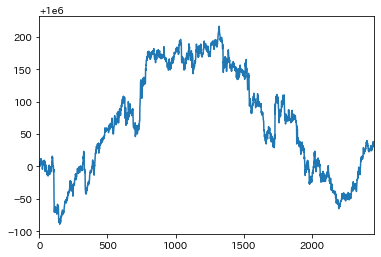

In [50]:
pos_df['assets'].plot()

In [337]:
get_evaluation(pos_df)

勝率: 50.85%
ペイオフレシオ: 1.0257
プロフィットファクター: 1.0614
期待値: 0.040円
最大ドローダウン: -345.2pips
ケリー基準: 2.94%


### BT2

In [21]:
# バックテスト2
def back_test2(df, m, seed_money, start='', end='', gran='M5', lot=10, kly_rate='None'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    tmp_i = 0
    assets = seed_money
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    pos_df = pd.DataFrame(columns=['lot', 'l_or_s', 'entry_date', 'entry_rate', 'exit_date', 'exit_rate', 'pips', 'profit', 'assets'])

    # 実行
    for i in range(3, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値
        # up or down (Open - Close)
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud1 > ud2 > ud3 > 0:
            if pos == 'None':
                pips = (exit_rate - entry_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'long', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_long'
                tmp_i = i
        # 下降トレンドと判断しショート
        if 0 > ud3 > ud2 > ud1:
            if pos == 'None':
                pips = (entry_rate - exit_rate - fee) * 100
                if kly_rate != 'None':
                    kly = assets * kly_rate
                    lot = math.floor(kly / exit_rate)
                profit = pips * lot / 100
                assets = round(assets + profit, 4)
                tmp_se = pd.Series([lot, 'short', df.iat[i, 0], entry_rate, df.iat[i+m, 0],
                                    exit_rate, pips, profit, assets], index=pos_df.columns)
                pos_df = pos_df.append(tmp_se, ignore_index=True)
                if pos_df.tail(1)['assets'].values[0] < 0:
                    break
                pos = 'entry_short'
                tmp_i = i
        
    print('pos count: {:>5}, assets: {:>6.0f}円'.format(pos_df.shape[0], pos_df.tail(1)['assets'].values[0]))
    return pos_df, df

In [22]:
# バックテスト簡易版2
def back_test_easy2(df, m, start='', end='', gran='M5'):
    pos = 'None'
    entry_rate = 0
    fee = 0.002
    profit_list = []
    pos_count = 0
    tmp_i = 0
    
    if isinstance(df, pd.DataFrame):
        pass
    else:
        df = get_data_super(start, end, gran)
    
    # 実行
    for i in range(3, len(df.index) - (1+m)):
        entry_rate = df.iat[i, 2] # 始値(entry)
        exit_rate = df.iat[i+m, 5] # m本後の終値(exit)
        # up or down (Open - Close) + なら赤 - なら緑
        ud1 = df.iat[i-1, 2] - df.iat[i-1, 5]
        ud2 = df.iat[i-2, 2] - df.iat[i-2, 5]
        ud3 = df.iat[i-3, 2] - df.iat[i-3, 5]
        
        # ポジションのリセット
        if tmp_i + m == i:
            pos = 'None'
        # 上昇トレンドと判断しロング
        if ud1 > ud2 > ud3 > 0:
            if pos == 'None':
                profit = exit_rate - entry_rate - fee
                profit_list.append(profit)
                pos = 'entry_long'
                pos_count+=1
                tmp_i = i
        # 下降トレンドと判断しショート
        if 0 > ud3 > ud2 > ud1:
            if pos == 'None':
                profit = entry_rate - exit_rate - fee
                profit_list.append(profit)
                pos = 'entry_short'
                pos_count+=1
                tmp_i = i
        
    print('pos count: {:>5}, profit: {:>6.3f}'.format(pos_count, sum(profit_list)))

#### M5

In [31]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy2(dfm5, m=i)

m: 1, pos count: 22805, profit: 10.478
m: 2, pos count: 20484, profit:  4.572
m: 3, pos count: 20284, profit: -4.849
m: 4, pos count: 19669, profit: 16.083
m: 5, pos count: 19116, profit: 16.840
m: 6, pos count: 18643, profit:  7.804
m: 7, pos count: 18168, profit: 19.359
m: 8, pos count: 17674, profit: 23.798
m: 9, pos count: 17242, profit: 24.977
m: 10, 

KeyboardInterrupt: 

#### M1

In [24]:
for i in range(1, 50):
    print('m: {}, '.format(i), end='')
    back_test_easy2(dfm1[dfm1['Time'].dt.year==2018], m=i)

m: 1, pos count:  9666, profit: -16.814
m: 2, pos count:  8756, profit: -10.506
m: 3, pos count:  8669, profit: -13.054
m: 4, pos count:  8452, profit: -12.096
m: 5, pos count:  8227, profit: -10.228
m: 6, pos count:  8025, profit: -9.483
m: 7, pos count:  7848, profit: -7.486
m: 8, pos count:  7684, profit: -4.259
m: 9, pos count:  7536, profit: -3.538
m: 10, pos count:  7348, profit: -3.418
m: 11, pos count:  7172, profit: -2.928
m: 12, pos count:  7025, profit: -4.017
m: 13, pos count:  6899, profit: -4.570
m: 14, pos count:  6746, profit: -4.591
m: 15, pos count:  6623, profit: -3.666
m: 16, pos count:  6516, profit: -4.765
m: 17, pos count:  6394, profit: -2.788
m: 18, pos count:  6273, profit: -2.422
m: 19, pos count:  6169, profit: -1.654
m: 20, pos count:  6056, profit: -3.113
m: 21, pos count:  5946, profit: -2.851
m: 22, pos count:  5822, profit: -2.602
m: 23, pos count:  5722, profit: -4.320
m: 24, pos count:  5623, profit: -3.878
m: 25, pos count:  5536, profit: -1.928
m: 2

In [28]:
pos_df2m12017, df = back_test2(dfm1[dfm1['Time'].dt.year==2017], m=36, seed_money=1000000)

pos count:  5143, assets: 999836円


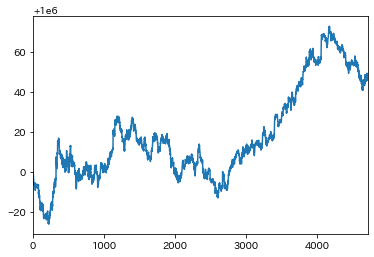

In [30]:
pos_df2m12018['assets'].plot()

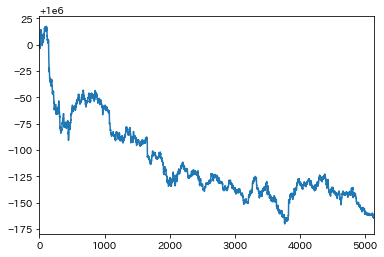

In [29]:
pos_df2m12017['assets'].plot()

#### BT2, M5, m=26

In [32]:
pos_df_M5_m26, df = back_test2(dfm5, m=26, seed_money=1000000)

pos count: 11939, assets: 1000346円


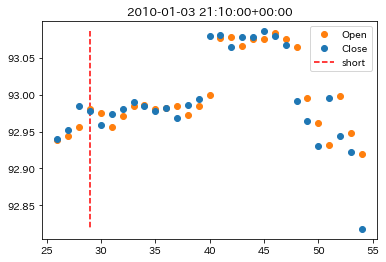

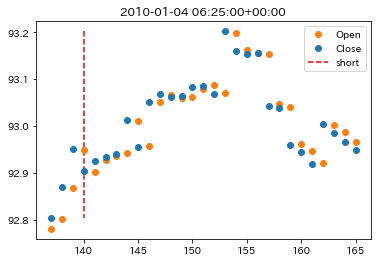

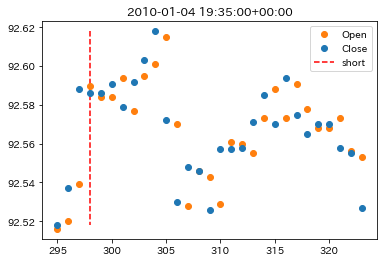

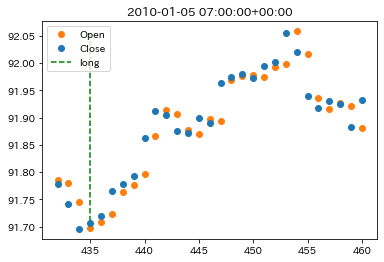

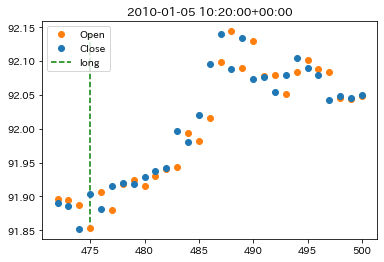

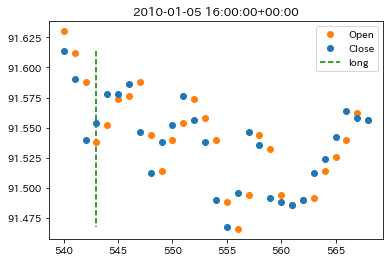

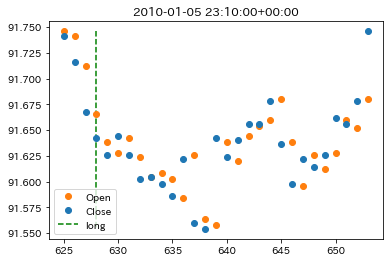

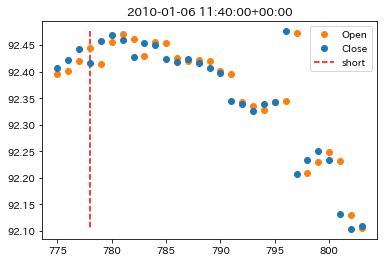

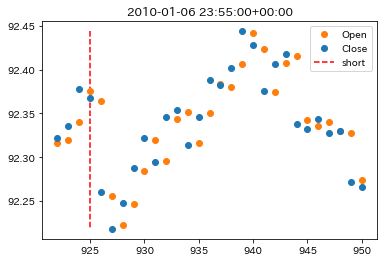

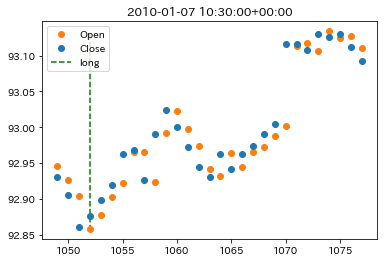

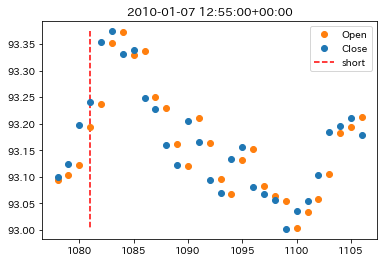

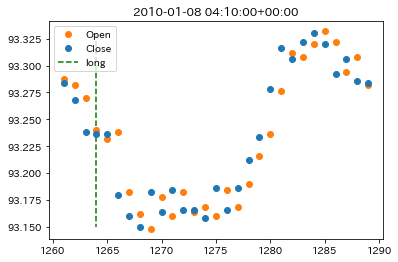

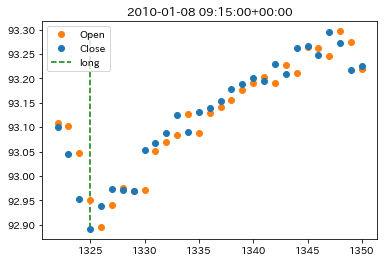

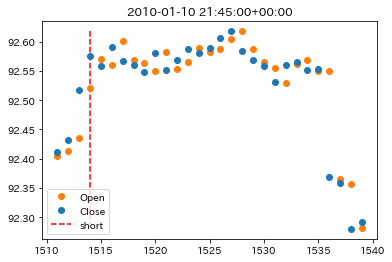

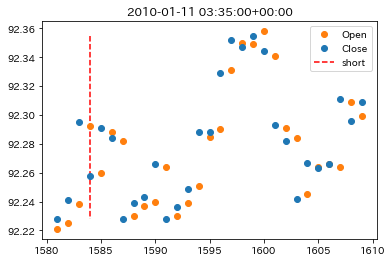

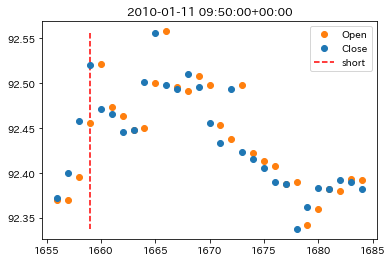

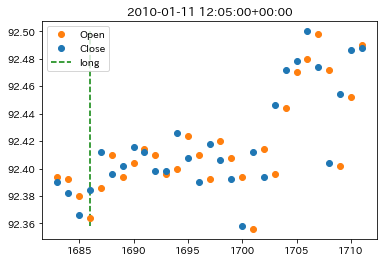

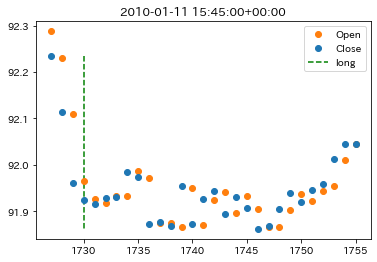

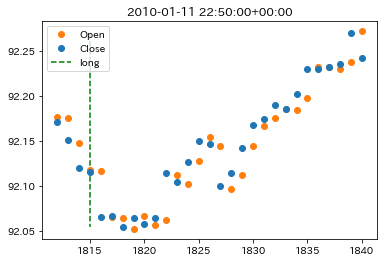

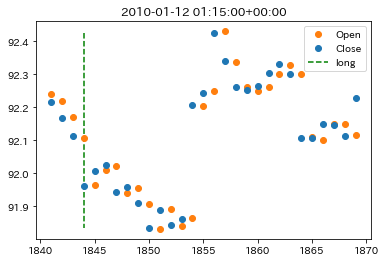

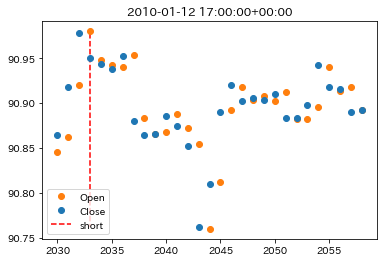

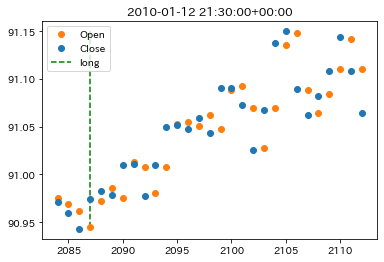

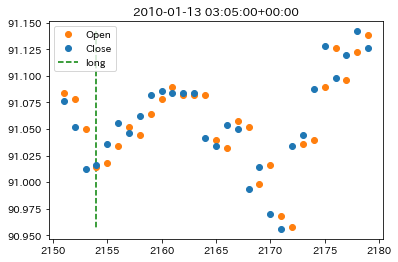

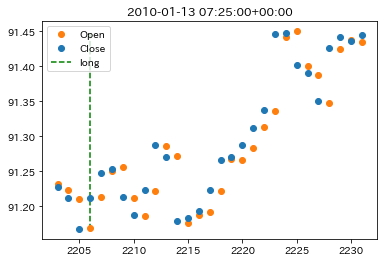

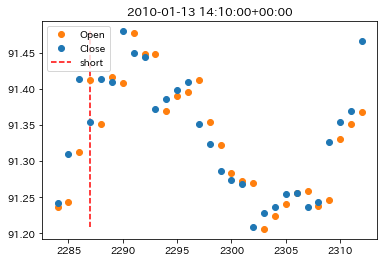

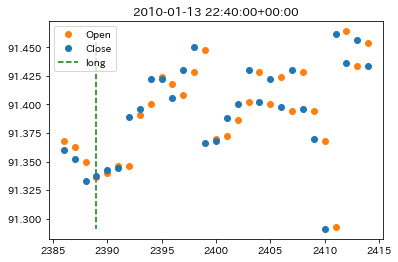

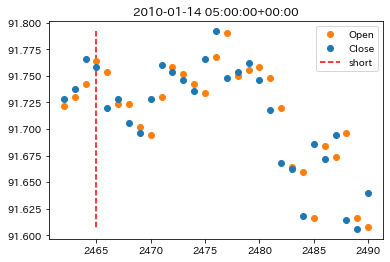

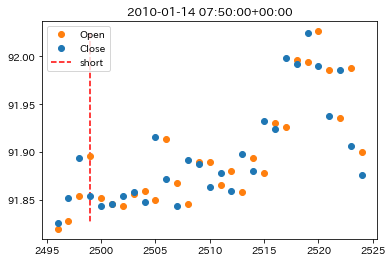

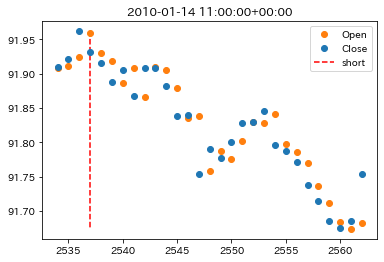

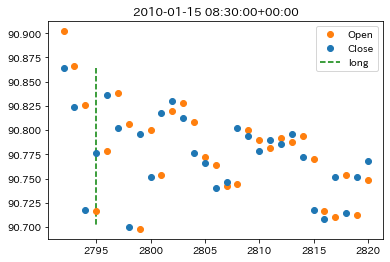

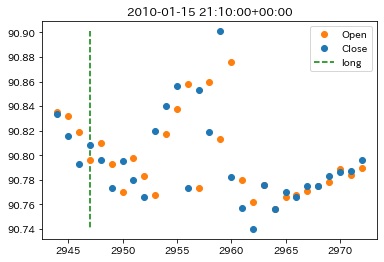

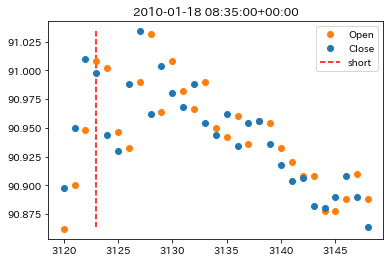

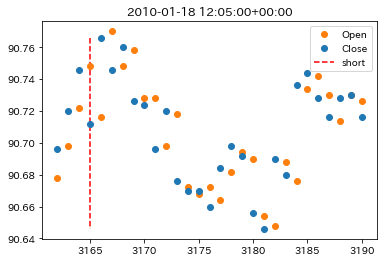

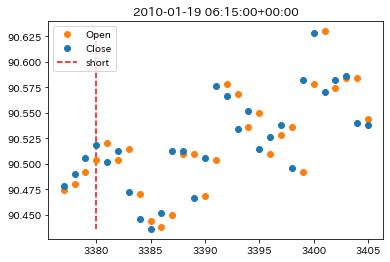

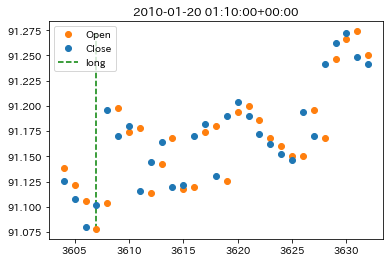

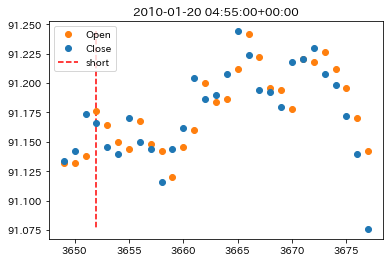

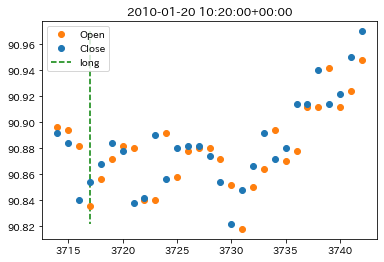

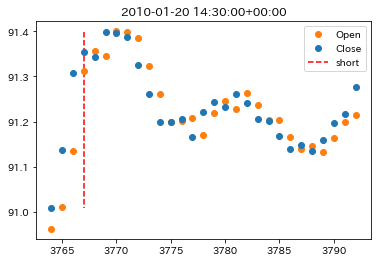

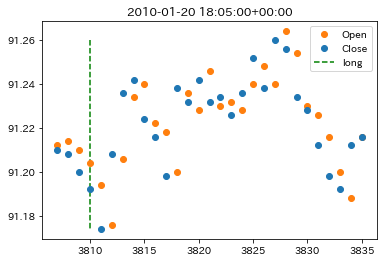

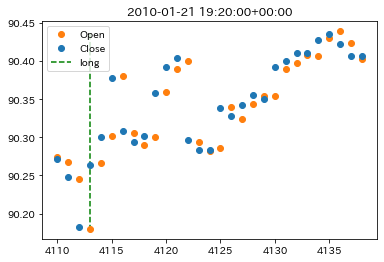

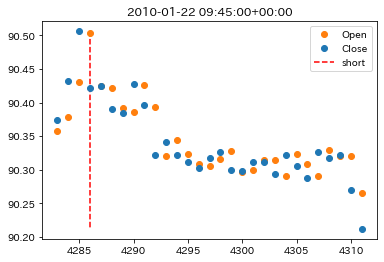

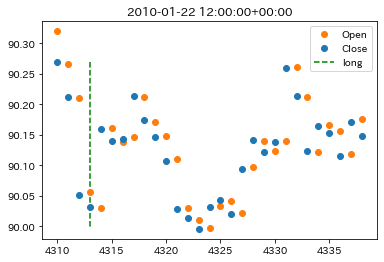

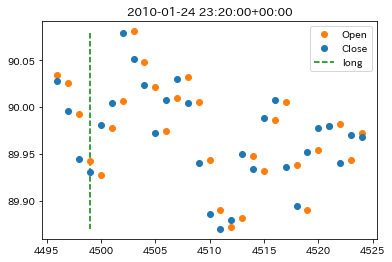

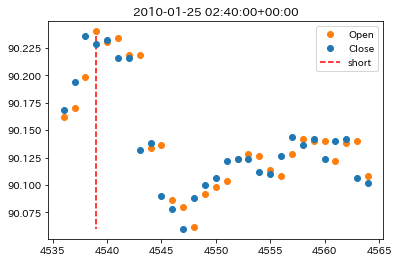

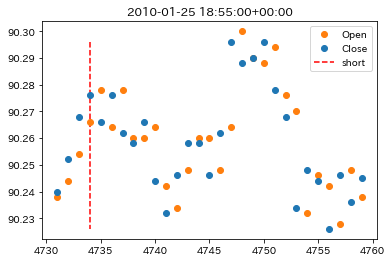

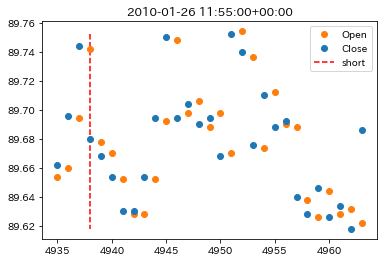

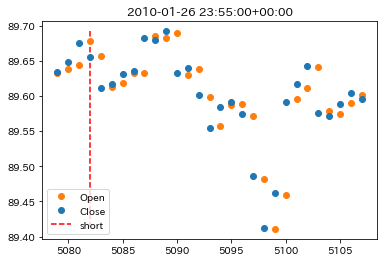

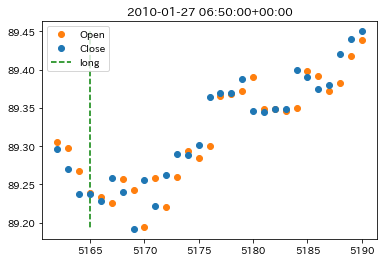

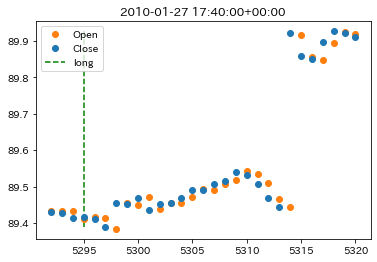

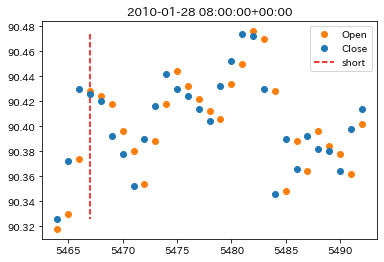

In [38]:
entry_plot(pos_df_M5_m26, dfm5, type_='win_head', m=26)

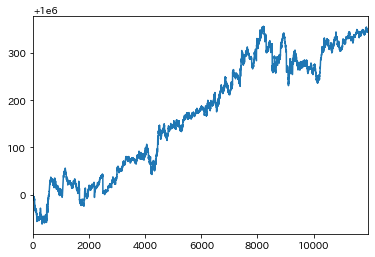

In [35]:
pos_df_M5_m26['assets'].plot()

#### BT2, M5, m=5

In [39]:
pos_df_M5_m5, df = back_test2(dfm5, m=5, seed_money=1000000)

pos count: 19116, assets: 1000168円


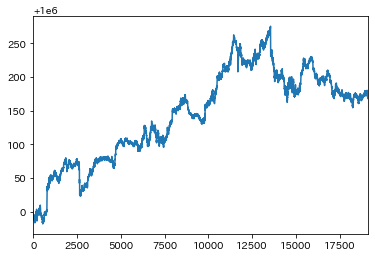

In [40]:
pos_df_M5_m5['assets'].plot()

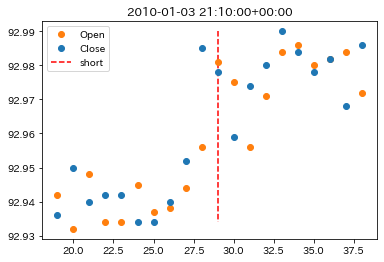

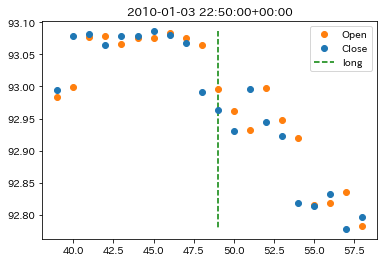

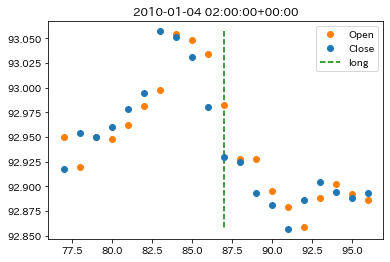

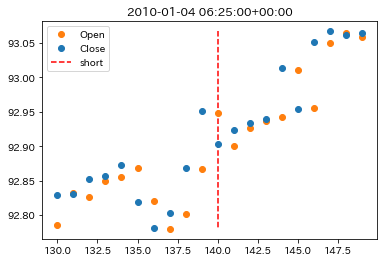

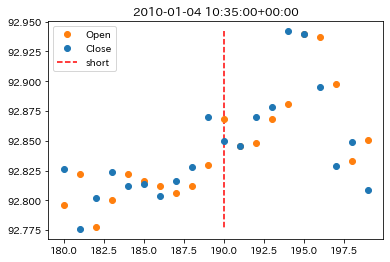

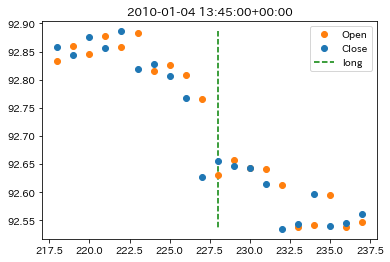

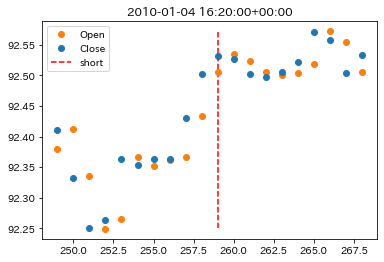

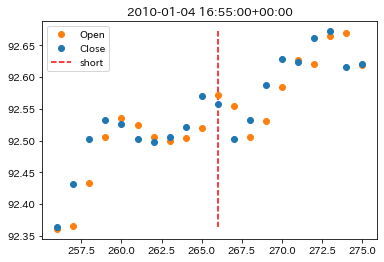

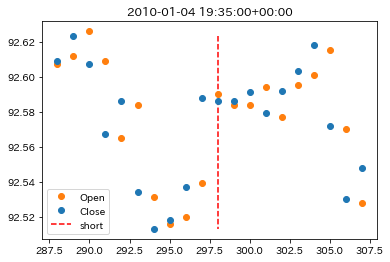

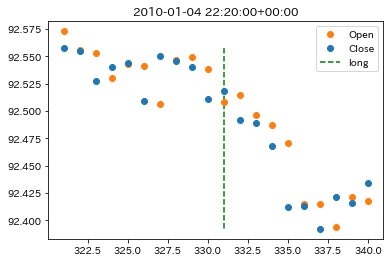

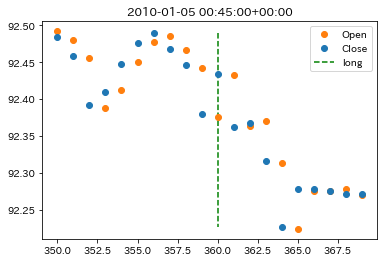

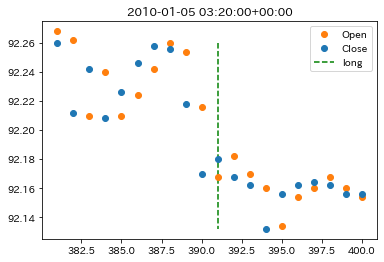

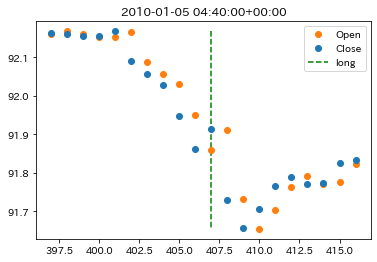

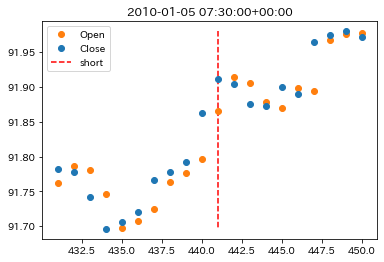

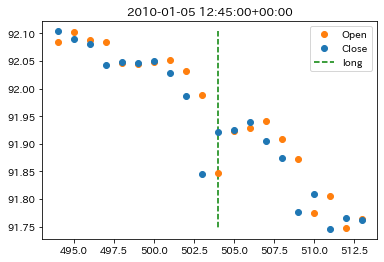

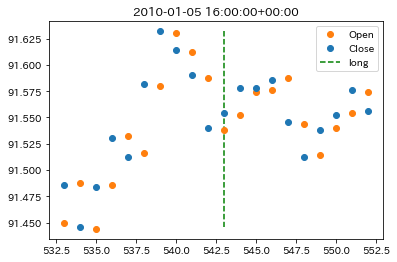

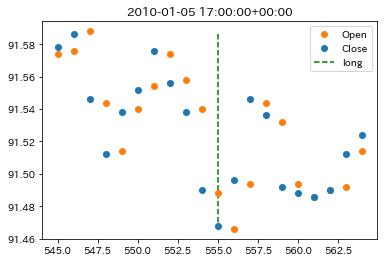

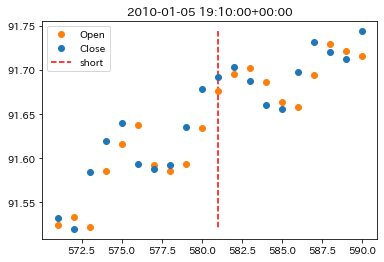

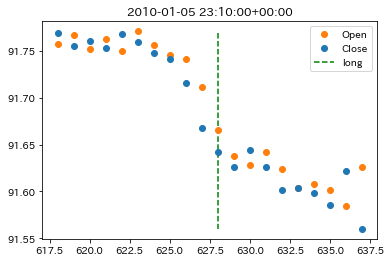

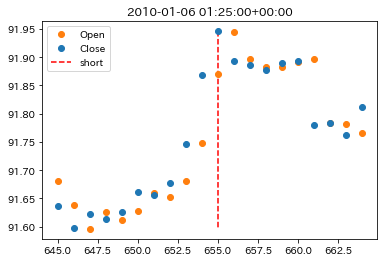

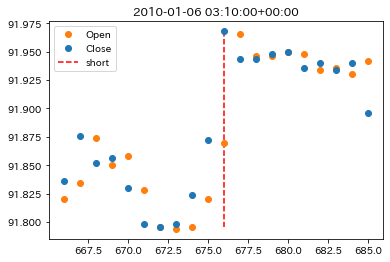

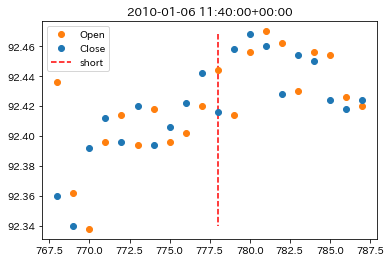

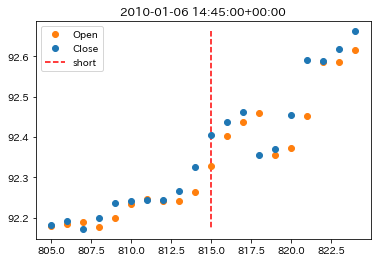

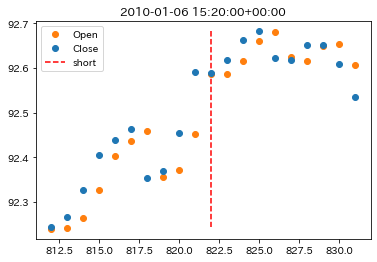

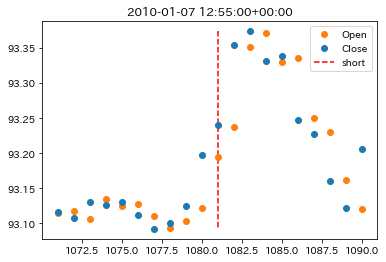

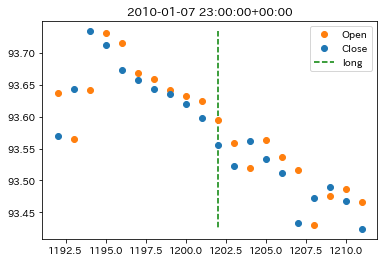

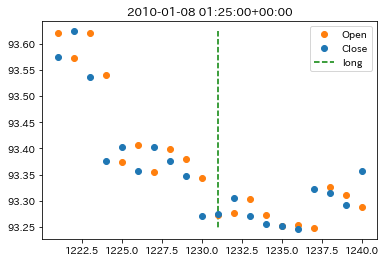

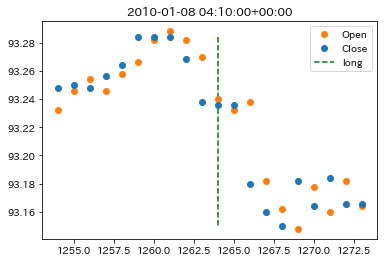

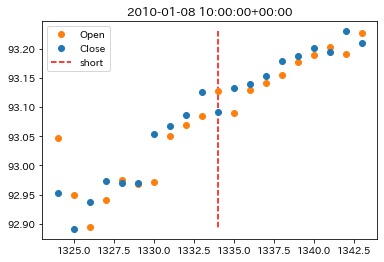

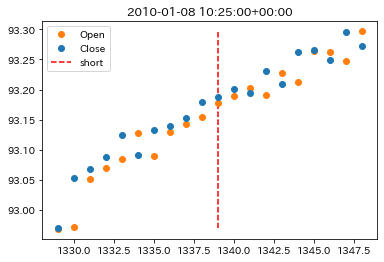

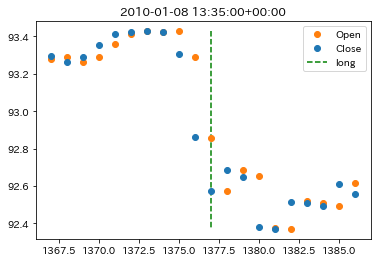

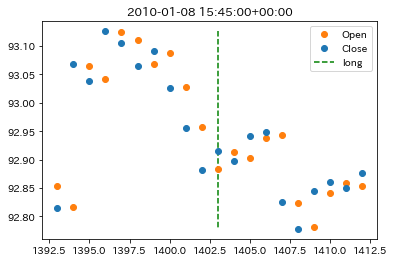

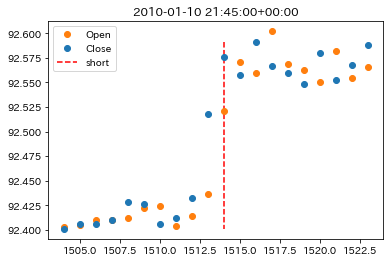

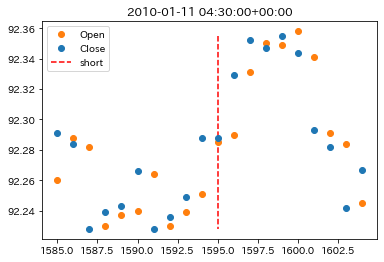

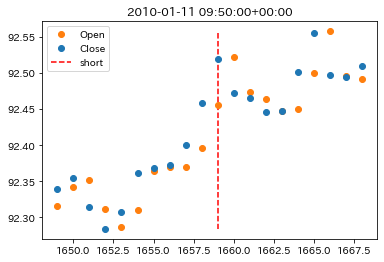

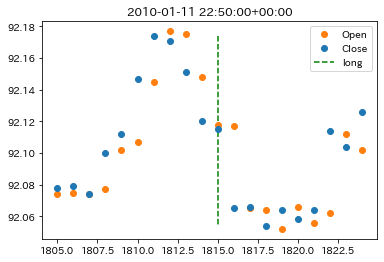

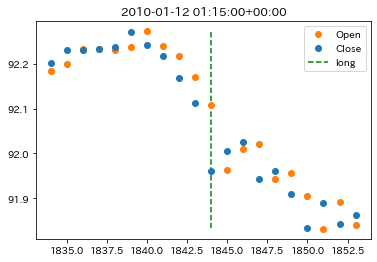

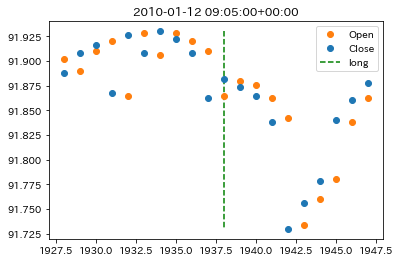

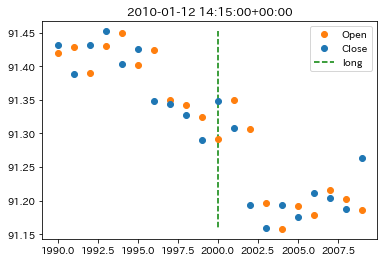

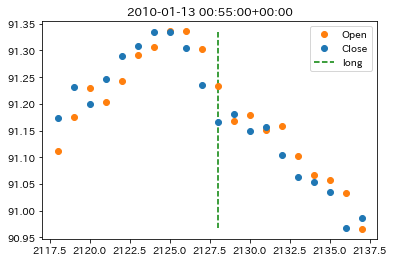

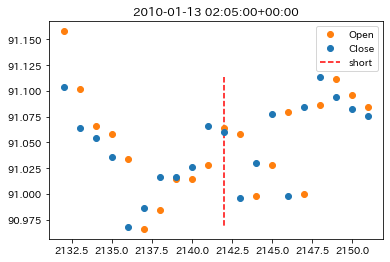

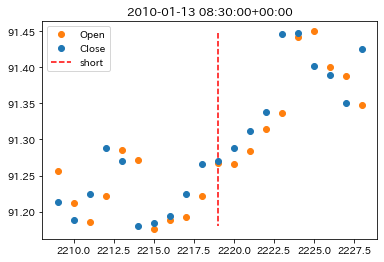

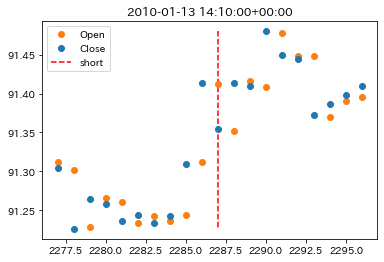

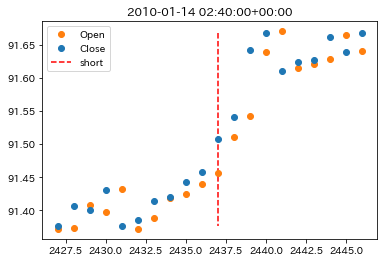

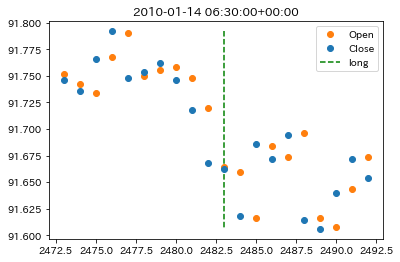

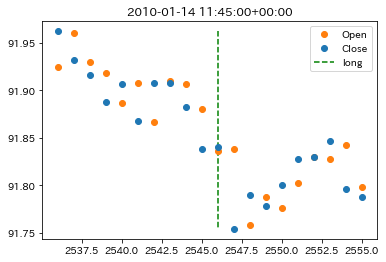

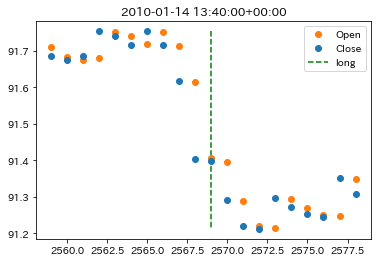

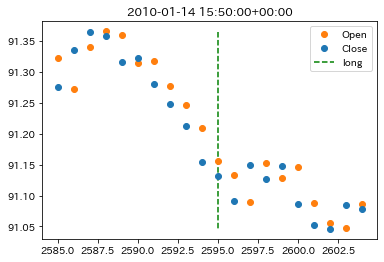

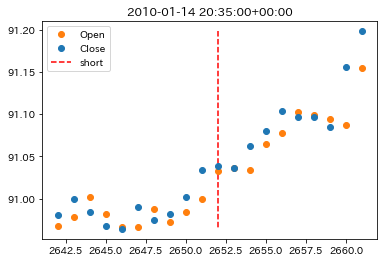

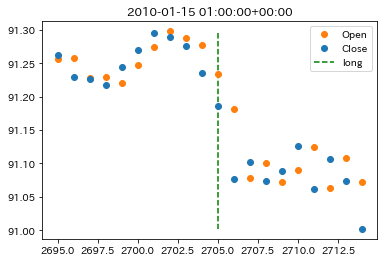

In [44]:
entry_plot(pos_df_M5_m5, dfm5, type_='lose_head', m=10, b=10)

#### m=???, plot

pos count: 22805, assets: 1000105円


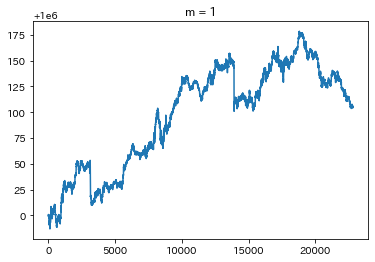

pos count: 20484, assets: 1000046円


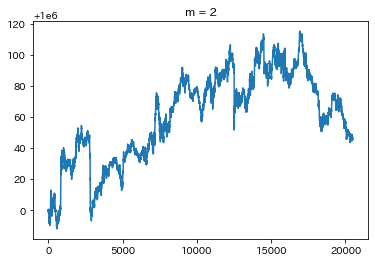

pos count: 20284, assets: 999952円


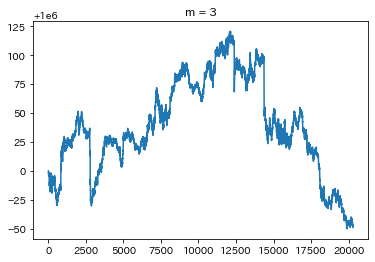

pos count: 19669, assets: 1000161円


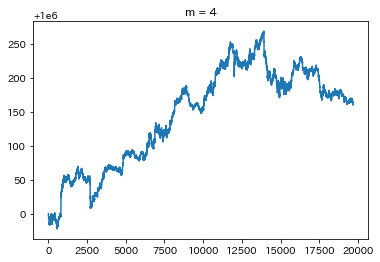

pos count: 19116, assets: 1000168円


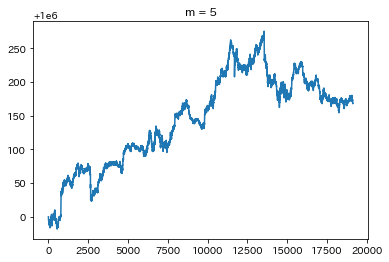

pos count: 18643, assets: 1000078円


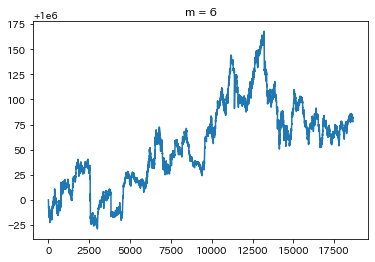

pos count: 18168, assets: 1000194円


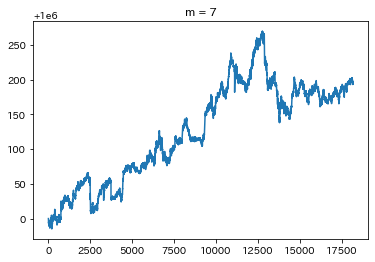

pos count: 17674, assets: 1000238円


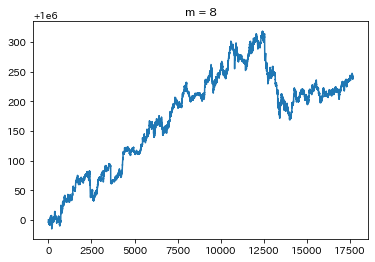

pos count: 17242, assets: 1000250円


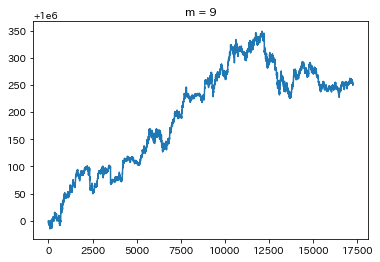

pos count: 16787, assets: 1000162円


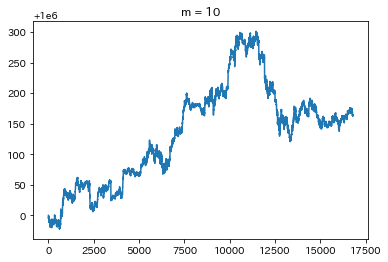

pos count: 16378, assets: 1000055円


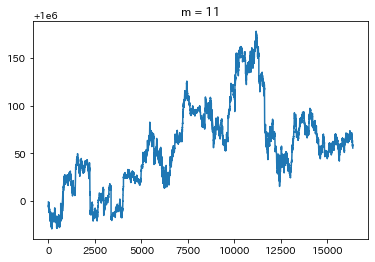

pos count: 16001, assets: 1000130円


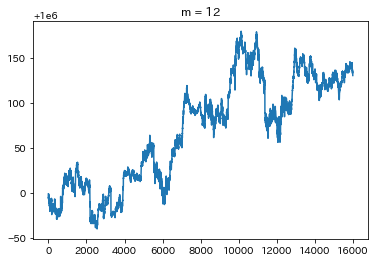

pos count: 15609, assets: 1000131円


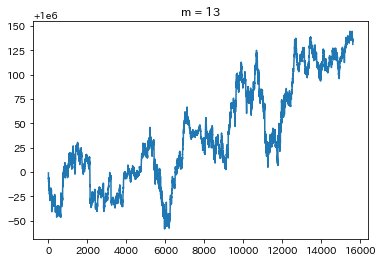

pos count: 15274, assets: 1000099円


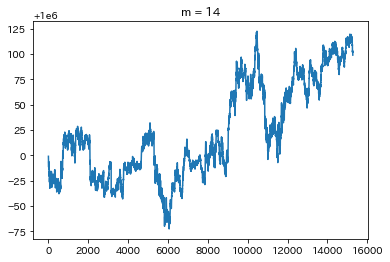

pos count: 14930, assets: 1000138円


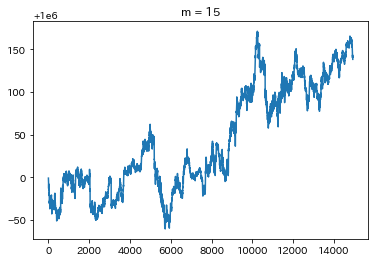

pos count: 14626, assets: 1000211円


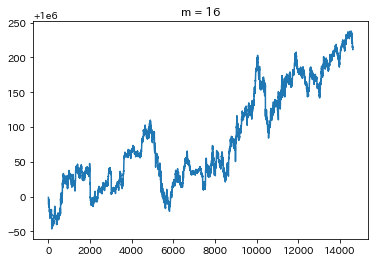

pos count: 14284, assets: 1000198円


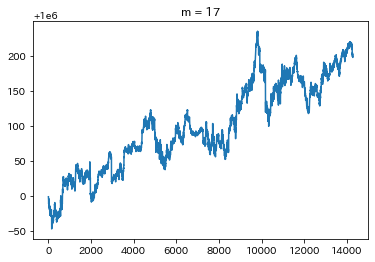

pos count: 13994, assets: 1000235円


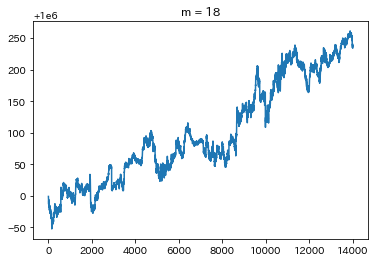

pos count: 13683, assets: 1000228円


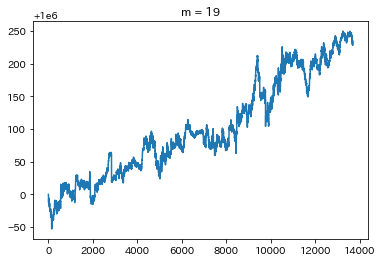

pos count: 13404, assets: 1000175円


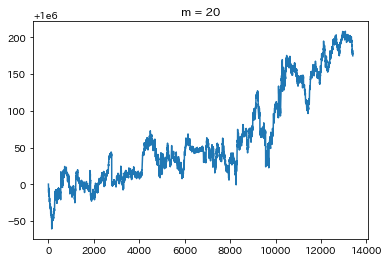

In [49]:
for i in range(20):
    pos_df, df = back_test2(dfm5, m=i+1, seed_money=1000000)
    plt.plot(pos_df['assets'])
    plt.title('m = {}'.format(i+1))
    plt.show()

pos count: 13134, assets: 1000124円


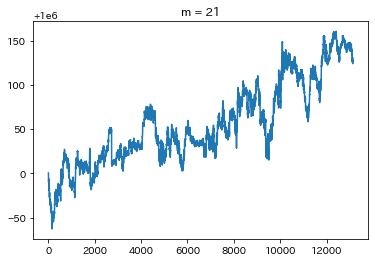

pos count: 12871, assets: 1000119円


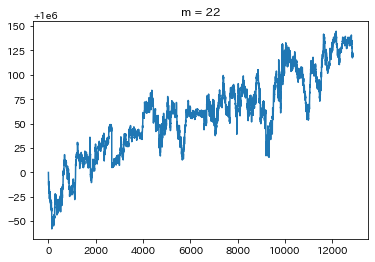

pos count: 12626, assets: 1000111円


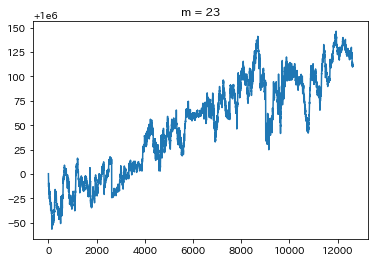

pos count: 12370, assets: 1000312円


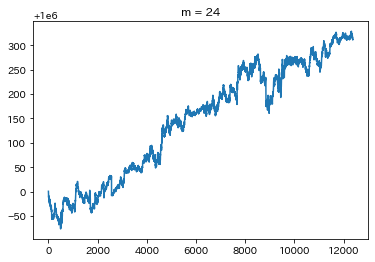

pos count: 12151, assets: 1000255円


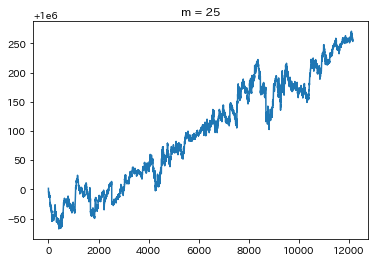

pos count: 11939, assets: 1000346円


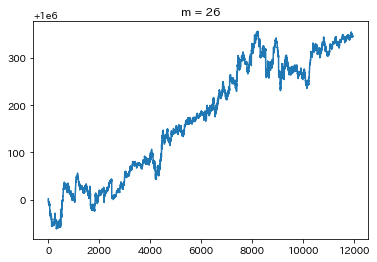

pos count: 11740, assets: 1000268円


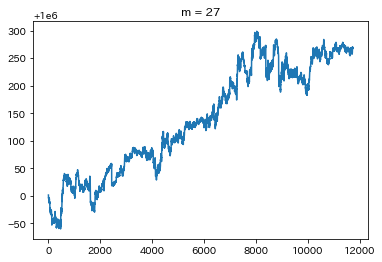

pos count: 11531, assets: 1000223円


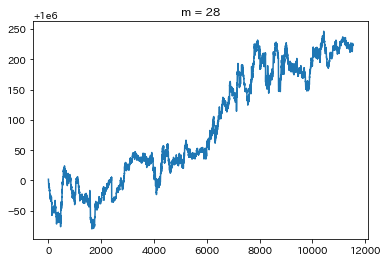

pos count: 11318, assets: 1000160円


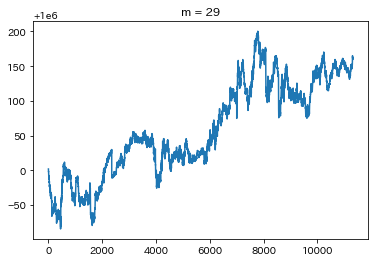

pos count: 11157, assets: 1000206円


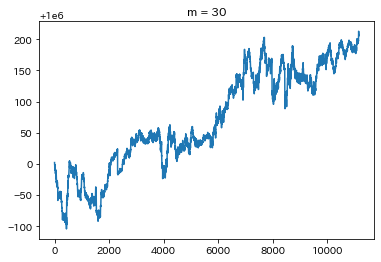

pos count: 10967, assets: 1000256円


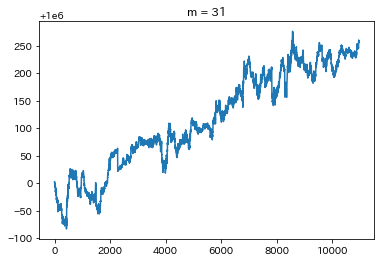

pos count: 10789, assets: 1000215円


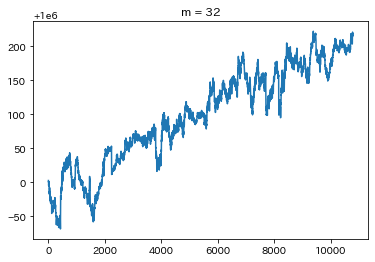

pos count: 10623, assets: 1000178円


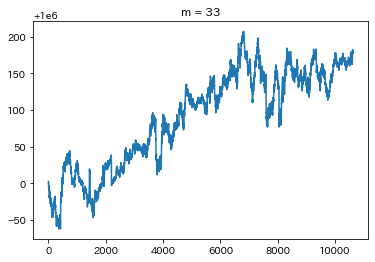

pos count: 10436, assets: 1000093円


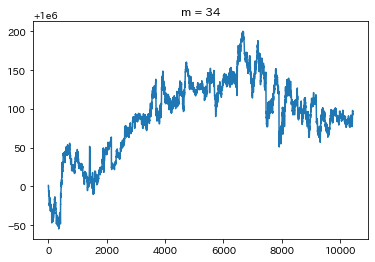

pos count: 10279, assets: 1000057円


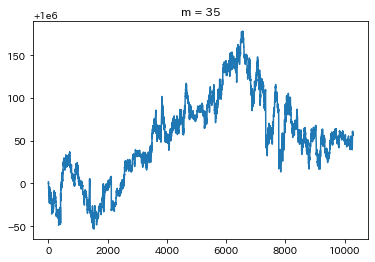

pos count: 10133, assets: 1000048円


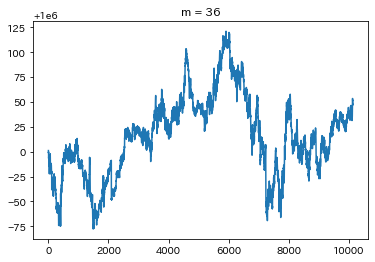

pos count:  9974, assets: 1000045円


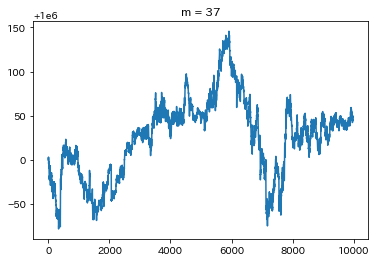

pos count:  9828, assets: 999981円


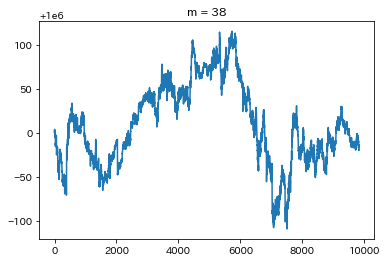

pos count:  9703, assets: 1000080円


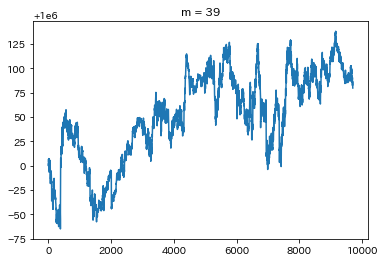

pos count:  9559, assets: 1000140円


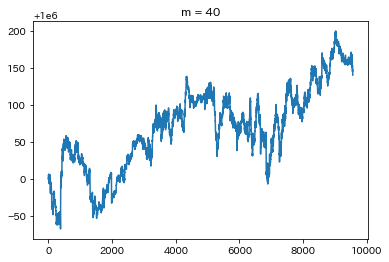

In [50]:
for i in range(20, 40):
    pos_df, df = back_test2(dfm5, m=i+1, seed_money=1000000)
    plt.plot(pos_df['assets'])
    plt.title('m = {}'.format(i+1))
    plt.show()